# Markov processes

## The concept of state in a process

- We refer to internal representation of the Process at time $t$ as the <i>State</i> of the Process at time $t$ and denote it as $S_t$. We are interested in the probability of the next State $S_{t+1}$, given the present State $S_t$ and the past States $S_0, S_1, ..., S_{t-1}$, i.e., $\mathbb{P}[S_{t+1}|S_t, S_{t-1},..., S_0]$.

## Understanding Markov property from stock price exmaples

- We will be learning about Markov Processses in this chapter, and these Processes have States that possess a property known as the Markov Property. So we will now learn about the Markov Property of States.

- Let us assume that from time step $t$ to the next time step $t+1$, the stock price can either go up by 1 or go down by 1, i.e., the only two outcomes for $X_{t+1}$ are $X_t+1$ or $X_t-1$. To understand the random evolution of the stock prices in time, we just need to quantify the probability of an up-move $\mathbb{P}[X_{t+1}=X_t+1]$ since the probability of a down-move $\mathbb{R}[X_{t+1}=X_t-1]=1-\mathbb{P}[X_{t+1}=X_t+1]$. We will consider 3 different processes for the evolution of stock prices.

### Process 1
$$\mathbb{P}[X_{t+1}=X_t+1]=\frac{1}{1+e^{-\alpha_1(L-X_t)}}$$

- where $L$ is an arbitrary reference level and $\alpha_1\in \mathbb{R}\ge 0$ is a "pull strength" parameter. This probability is defined as a logistic function of $L-X$ with the stepness of the logistic function controlled by the parameter $\alpha_1$.

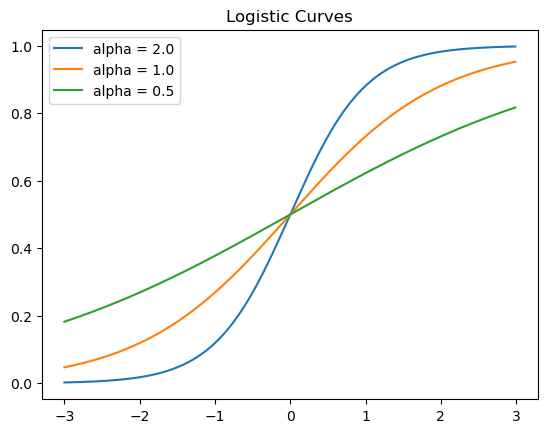

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

X = np.arange(-3, 3, 0.01)

def sigmoid(x, alpha):
    return 1 / (1 + np.exp(-x * alpha))

y1 = sigmoid(X, 2.0)
y2 = sigmoid(X, 1.0)
y3 = sigmoid(X, 0.5)

plt.plot(X, y1, label='alpha = 2.0')
plt.plot(X, y2, label='alpha = 1.0')
plt.plot(X, y3, label='alpha = 0.5')
plt.legend()
plt.title("Logistic Curves")
plt.show()


- The way to interpret this logistic function of $L-X_t$ is: if $X_t$ is greater than the reference level $L$ (making $\mathbb{P}[X_{t+1}=X_t+1]<0.5)$, then there is more of a down-pull than an up-pull. Likewise, if $X_t$ is less than $L$, then there is more of an up-pull. The extent of the pull is controlled by the magnitude of the parameter $\alpha_1$. We refer to this behavior as mean-reverting behavior, meaning the stock price tends to revert to the mean.

- We can model the State $S_t=X_t$ and note that the probabilities of the next State $S_{t+1}$ depend only on the current State $S_t$ and not on the previous States $S_0, S_1, ..., S_{t-1}$.

$$ \mathbb{P}[S_{t+1}|S_t, S_{t-1}, ..., S_0]=\mathbb{P}[S_{t+1}|S_t] \text{ for all } t\ge0$$

- We call this the Markov Property of States, or simply that these are Markov States.

- Let us code this up.

    - Firstly, we create a dataclass to represent the dynamics of this process. The dataclass `Process1` contains two attributes `level_param`: `int` and `alpha1: float = 0.25` to represent $L$ and $\alpha_1$.

    - It contains the method `up_prob` to calculate $\mathbb{P}[X_{t+1}=X_t+1]$ and the method `next_state`, which samples from a Bernoulli distribution (whose probability is obtained from the method `up_prob`) and creates the next state $S_{t+1}$ from the current state $S_t$.

    - Note the. nested dataclass `State` meant to represent the state pf Process 1 (its only attribute `price: int` reflects the fact that the state consits of only the current price.)

In [2]:
import numpy as np
from dataclasses import dataclass

@dataclass
class Process1:
    @dataclass
    class State:
        price: int
    level_param: int    # level to which price mean-reverts
    alpha1: float = 0.25 # strength of mean-reversion (non-negaive value)
    
    def up_prob(self, state: State) -> float:
        return 1. / (1 + np.exp(-self.alpha1 * (self.level_param - state.price)))
    
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process1.State(price=state.price + up_move * 2 - 1)

- Next, we write a simple simulator using Python's generator functionality (using `yield`).

In [3]:
def simulation(process, start_state):
    state = start_state
    while True:
        yield state
        state = process.next_state(state)

- We generate `num_traces` number of sampling traces over `time_steps` number of time steps starting a price $X_0$ of `start_price`.

In [7]:
import itertools

def process1_price_traces(
    start_price: int,
    level_param: int,
    alpha1: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process1(level_param=level_param, alpha1=alpha1)
    start_state = Process1.State(price=start_price)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)
    ])

In [8]:
start_price = 100
level_param = 100
alpha1 = 0.25
times_steps = 100
num_traces = 1000

process1_traces = process1_price_traces(
    start_price=start_price,
    level_param=level_param,
    alpha1=alpha1,
    time_steps=times_steps,
    num_traces=num_traces
)

In [11]:
process1_traces

array([[100., 101., 102., ..., 100., 101., 100.],
       [100., 101., 100., ..., 102., 103., 104.],
       [100.,  99.,  98., ..., 100.,  99.,  98.],
       ...,
       [100., 101., 102., ...,  98.,  99.,  98.],
       [100.,  99.,  98., ..., 102., 103., 104.],
       [100.,  99.,  98., ..., 100.,  99., 100.]])

### Process 2
$$ \mathbb{P}[X_{t+1}=X_t+1]=\begin{cases}
0.5(1-\alpha_2(X_t-X_{t-1}))& \text{if } t>0\\
0.5 & t =0
\end{cases}$$

- where $\alpha_2$ is "pull strength" parameter in the closed intervsal $[0, 1]$. The intuition is that the direction of the next move $X_{t+1}-X_t$ is biased in the reverse direction of the previous move $X_t-X_{t-1}$, and the extent of the bias is controlled by the parameter $\alpha_2$.

- We note that if we model the state $S_t$ as $X_t$, we won't satisfy the Markov Property because the probabilities of $X_{t+1}$ depend on not just $X_t$ but also on $X_{t-1}$. We can perform a little trick here and create an augmented state $S_t$ consiting of the pair $(X_t, X_t-X_{t-1})$. We can see that the Markov Property is indeed satisfied:

$$\mathbb{P}[(X_{t+1}, X_{t+1}-X_t)|(X_t, X_t-X_{t-1}), (X_{t-1}, X_{t-1}-X_{t-2}), ..., (X_0, Null)] \\= \mathbb{P}[(X_{t+1}, X_{t+1}-X_t)|(X_t, X_t-X_{t-1})]=0.5(1-\alpha_2(X_{t+1}-X_t)(X_t-X_{t-1}))$$

- The corresponding dataclass for Process 2 is shown below:

In [12]:
from typing import Optional, Mapping
handy_map: Mapping[Optional[bool], int] = {True: -1, False: 1, None: 0}

@dataclass
class Process2:
    @dataclass
    class State:
        price: int
        is_prev_move_up: Optional[bool]
    alpha2: float = 0.75        # strength of reverse-pull (value in [0, 1])
    
    def up_prob(self, state: State) -> float:
        return 0.5 * (1 + self.alpha2 * handy_map[state.is_prev_move_up])
    def next_state(self, state: State) -> State:
        up_move: int = np.random.binomial(1, self.up_prob(state), 1)[0]
        return Process2.State(
            price=state.price + up_move * 2 - 1,
            is_prev_move_up=bool(up_move)
        )

In [13]:
def process2_price_traces(
    start_price: int,
    alpha2: float,
    time_steps: int,
    num_traces: int
) -> np.ndarray:
    process = Process2(alpha2=alpha2)
    start_state = Process2.State(price=start_price, is_prev_move_up=None)
    return np.vstack([
        np.fromiter((s.price for s in itertools.islice(
            simulation(process, start_state),
            time_steps + 1
        )), float) for _ in range(num_traces)
    ])

In [14]:
alpha2 = 0.75
process2_traces = process2_price_traces(
    start_price=start_price,
    alpha2=alpha2,
    time_steps=times_steps,
    num_traces=num_traces
)
process2_traces

array([[100.,  99., 100., ..., 102., 101., 102.],
       [100., 101., 100., ...,  98.,  99.,  98.],
       [100., 101., 100., ...,  96.,  95.,  96.],
       ...,
       [100.,  99.,  98., ...,  98.,  97.,  98.],
       [100., 101., 100., ..., 108., 107., 106.],
       [100.,  99., 100., ..., 104., 105., 106.]])